# Getting started with tket2

This demo notebook gives an overview of currently implemented tket2 features.

Be aware that the library is still in development and some features may not be
fully implemented or may change in the future.



## Installation

To install the library, you can use pip:

In [18]:
# Install required dependencies
!uv pip install \
    "pytket>=1.30.0,<2" \
    "guppylang>=0.12.0,<0.13" \
    "hugr>=0.8.1,<0.9" \

# Uncomment one of these lines depending on whether you are using a published
# version of tket2 or a local build.
#!uv pip install "tket2>=0.4.0,<0.5"
!cd ../../ && maturin develop --quiet --uv

Audited 3 packages in 2ms
⚠️  Warning: `build-backend` in pyproject.toml is not set to `maturin`, packaging tools such as pip will not use maturin to build this project.
🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.12 at /Users/aborgna/src/tket2/.venv/bin/python
📡 Using build options features from pyproject.toml
📦 Built wheel for CPython 3.12 to /var/folders/3j/ktpgz6yj0gn05q3x3d0qqndw0000gn/T/.tmpGBLlUC/tket2_py-0.0.0-cp312-cp312-macosx_11_0_arm64.whl
✏️  Setting installed package as editable
🛠 Installed tket2-py-0.0.0


In [19]:
from tket2.circuit import Tk2Circuit
import math

Let's configure pretty printing for the circuits, using the mermaid renderer.
This will render the circuit graphs in `jupyter-lab`, but it is not currently supported when viewing the library in vscode.

In [20]:
from utils import setup_jupyter_rendering # type: ignore
# NOTE: This requires having `dot` (aka graphviz) installed on your system.
setup_jupyter_rendering()

# Defining circuits

There are multiple ways for defining circuits in tket2.
The library provides two limited builders, and it supports importing circuits from `guppy` and `pytket`.

### Using the commands-based builder

The simplest way is to use the commands-based builder interface `CircBuild`.
It supports constructing circuits by listing a series of commands applied to specific qubits.

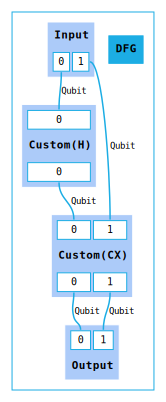

In [21]:
from tket2.circuit.build import CircBuild, H, CX

builder = CircBuild.with_nqb(2)

builder.extend(H(0), CX(0, 1))
builder.set_tracked_outputs()
circ = builder.finish()
circ

### Using the Dataflow Builder

`CircBuild` can also be used to build arbitrary dataflow graphs. It lets you connect arbitrary inputs and outputs to each operation.
This way, you can define circuits that read the same boolean multiple times, or allocate qubits dynamically.

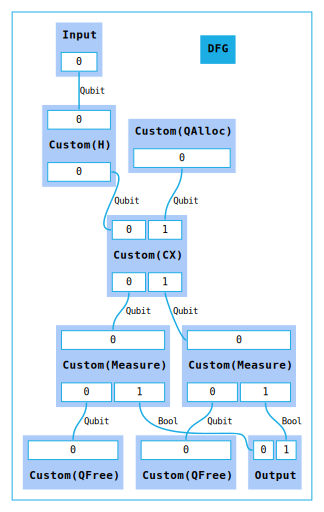

In [22]:
from tket2.circuit.build import CircBuild, QAlloc, H, CX, Measure, QFree


# Start building DFG with one qubit input
builder = CircBuild.with_nqb(1)

# Qubits and booleans are identified by their "Wires" in the graph.
# We can get the wire for the single input qubit.
[q0] = builder.inputs()

# And allocate a new qubit, indexing the `Node` output gets the outgoing "Wire".
q1 = builder.add(QAlloc())[0]

# Each operation returns the new wires it creates.
q0 = builder.add(H(q0))[0]
q0, q1 = builder.add(CX(q0, q1))[0, 1]

# Some operations may have different numbers of inputs and outputs.
[q0, b0] = builder.add(Measure(q0))[0, 1]
[q1, b1] = builder.add(Measure(q1))[0, 1]

# And some may have no outputs at all.
builder.add(QFree(q0))
builder.add(QFree(q1))

# To get the final circuit, we need to set the outputs then call finish().
builder.set_outputs(b0, b1)
circ = builder.finish()

circ

### Using pytket

We can convert from and to `pytket` circuits.

In [23]:
from pytket.circuit import Circuit as PytketCircuit
from pytket.circuit.display import render_circuit_jupyter

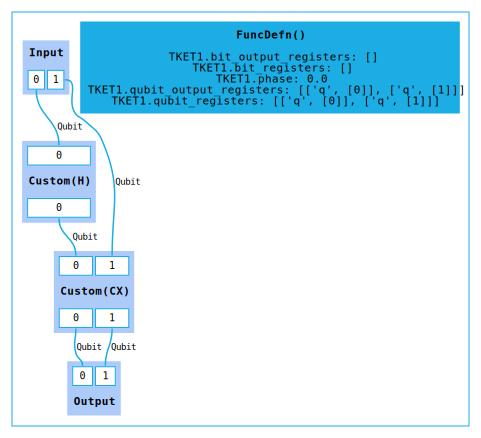

In [24]:
tk1_circ = PytketCircuit(2).H(0).CX(0, 1)
render_circuit_jupyter(tk1_circ)

circ = Tk2Circuit(tk1_circ)
circ

### Using guppy

Finally, if you have a circuit defined in `guppy` it can be imported directly into a `Tk2Circuit` object.

In [25]:
from guppylang import guppy
from guppylang.module import GuppyModule
from guppylang.prelude import quantum
from guppylang.prelude.builtins import py
from guppylang.prelude.quantum import measure, phased_x, qubit, rz, zz_max

# We define a utility function to convert a GuppyModule to a Tk2Circuit.
# This will be included with guppy in the future.
from utils import guppy_to_circuit # type: ignore

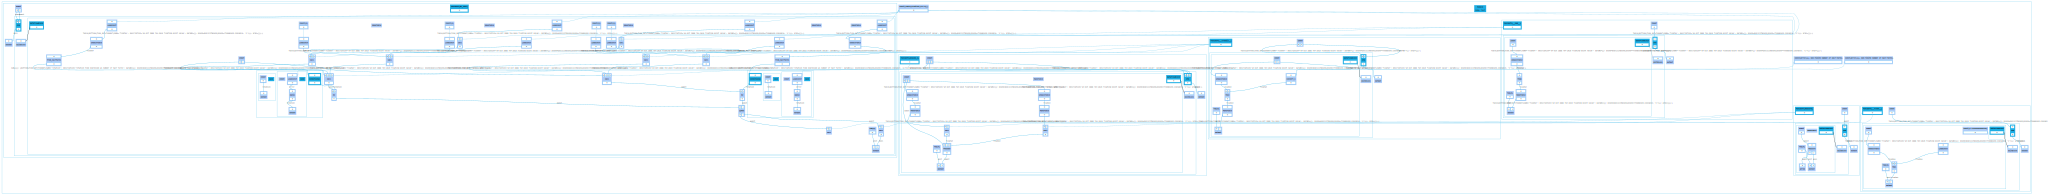

In [26]:
# Define a guppy module with a quantum function
from guppylang.prelude.quantum import measure, phased_x, qubit, rz, zz_max
from guppylang.prelude.angles import pi
from guppylang.prelude.builtins import owned

module = GuppyModule("test")
module.load_all(quantum)
module.load(pi)

@guppy(module)
def my_func(q0: qubit @owned, q1: qubit @owned) -> bool:
    phased_x(q0, pi / 2, -pi / 2)
    rz(q0, pi)
    phased_x(q1, pi / 2, -pi / 2)
    rz(q1, pi)
    zz_max(q0, q1)
    _ = measure(q0)
    return measure(q1)

hugr = module.compile()
circ = guppy_to_circuit(my_func)
hugr.modules[0]


In [27]:
print(hugr.to_json())

{"modules":[{"version":"live","nodes":[{"parent":0,"op":"Module"},{"parent":0,"op":"FuncDefn","name":"my_func","signature":{"params":[],"body":{"t":"G","input":[{"t":"Q"},{"t":"Q"}],"output":[{"t":"Sum","s":"Unit","size":2}],"extension_reqs":[]}}},{"parent":1,"op":"Input","types":[{"t":"Q"},{"t":"Q"}]},{"parent":1,"op":"Output","types":[{"t":"Sum","s":"Unit","size":2}]},{"parent":1,"op":"CFG","signature":{"t":"G","input":[{"t":"Q"},{"t":"Q"}],"output":[{"t":"Sum","s":"Unit","size":2}],"extension_reqs":[]}},{"parent":4,"op":"DataflowBlock","inputs":[{"t":"Q"},{"t":"Q"}],"other_outputs":[{"t":"Sum","s":"Unit","size":2}],"sum_rows":[[]],"extension_delta":[]},{"parent":5,"op":"Input","types":[{"t":"Q"},{"t":"Q"}]},{"parent":5,"op":"Output","types":[{"t":"Sum","s":"Unit","size":1},{"t":"Sum","s":"Unit","size":2}]},{"parent":4,"op":"ExitBlock","cfg_outputs":[{"t":"Sum","s":"Unit","size":2}]},{"parent":0,"op":"FuncDefn","name":"phased_x","signature":{"params":[],"body":{"t":"G","input":[{"t":

This can be combined with the pytket conversion to obtain a `pytket` circuit from a guppy definition!

NOTE: guppy -> pytket compatibility is currently broken, while we sync in the latest changes in guppy 0.12.

In [28]:
#tk1_circ = circ.to_tket1()
#render_circuit_jupyter(tk1_circ)

PyTK1ConvertError: Cannot serialize tket2 operation: ExtensionOp(ExtensionOp { def: OpDef { extension: IdentList("prelude"), name: "MakeTuple", description: "MakeTuple operation", misc: {}, signature_func: PolyFuncTypeBase { params: [List { param: Type { b: Any } }], body: FuncTypeBase { input: TypeRowBase { types: [TypeBase(RowVar(RowVariable(0, Any)), Any)] }, output: TypeRowBase { types: [TypeBase(Sum(General { rows: [TypeRowBase { types: [TypeBase(RowVar(RowVariable(0, Any)), Any)] }] }), Any)] }, extension_reqs: ExtensionSet({}) } }, lower_funcs: [], constant_folder: Some(<custom constant folding>) }, args: [Sequence { elems: [] }], signature: FuncTypeBase { input: TypeRowBase { types: [] }, output: TypeRowBase { types: [TypeBase(Sum(Unit { size: 1 }), Copyable)] }, extension_reqs: ExtensionSet({IdentList("prelude")}) } })